# Mine domain 3. Extract subgroups with high concentration of PHAs

In [3]:
# import string
# import math
# import itertools

from  copy import deepcopy
import pickle
import numpy as np
import pandas as pd
from sklearn import neighbors, svm
import matplotlib as mpl

# import matplotlib.pyplot as plt
# import scipy.stats as ss
# from sklearn.neighbors.kde import KernelDensity
# from sklearn import preprocessing as pp
# from sklearn import tree
# import pydotplus

# Import Asterion modules
import read_database as rdb
# import generate_orbits as go
import learn_data as ld
import asterion_learn as al
import visualize_data as vd

# Matplotlib settings for the current notebook
%matplotlib inline
font = {'size': 14}
mpl.rc('font', **font)

** Load NEAs from the 3-rd domain **

In [4]:
dirpath = './asteroid_data/'
gen_datasets = ['haz_gen', 'nohaz_gen']
genu_datasets = ['haz_gen', 'nohaz_gen']
name_sufixes = ['_sg3.p', '_sg3_rest.p']

In [5]:
dumps_gen = [dirpath + ds + ns for ns in name_sufixes for ds in gen_datasets]
dumps_genu = [dirpath + ds + ns for ns in name_sufixes for ds in genu_datasets]

haz_gen, nohaz_gen, haz_gen_rest, nohaz_gen_rest = map(rdb.loadObject, dumps_gen)
haz_genu, nohaz_genu, haz_genu_rest, nohaz_genu_rest = map(rdb.loadObject, dumps_genu)

** Investigate distributions of NEAs orbital parameters in the 3-rd domain **

In [1]:
# vd.display_allparams([haz_gen, nohaz_gen], vd.combs, vd.colnames)

In [2]:
# cutcol = ['w', 'i']
# labels = [vd.colnames[nm] for nm in cutcol]
# vd.display_param2d(cutcol, labels, [haz_gen, nohaz_gen])

** Declare containers to collect subgroups **

In [37]:
haz_extracted = []
nohaz_trapped = []

## Extract Atiras and Atens

In [6]:
haz_gen_atiras, haz_gen_atiras_num = rdb.get_atiras(haz_gen)
nohaz_gen_atiras, nohaz_gen_atiras_num = rdb.get_atiras(nohaz_gen)

In [7]:
haz_gen_atens, naz_gen_atens_num = rdb.get_atens(haz_gen)
nohaz_gen_atens, nohaz_gen_atens_num = rdb.get_atens(nohaz_gen)

In [8]:
haz_gen_atiras_atens = pd.concat((haz_gen_atiras, haz_gen_atens))
nohaz_gen_atiras_atens = pd.concat((nohaz_gen_atiras, nohaz_gen_atens))
haz_gen_atiras_atens_num = len(haz_gen_atiras_atens)
nohaz_gen_atiras_atens_num = len(nohaz_gen_atiras_atens)

In [9]:
# vd.display_allparams([haz_gen_atiras_atens, nohaz_gen_atiras_atens], vd.combs, vd.colnames)

** Amplify datasets by their symetric copies over the 'w' parameter **

In [11]:
haz_gen_atiras_atens_se = ld.add_doublemirror_column(haz_gen_atiras_atens, 'w', 180.0)
nohaz_gen_atiras_atens_se = ld.add_doublemirror_column(nohaz_gen_atiras_atens, 'w', 180.0)

** Split Atiras and Atens by 'w-i' surface **

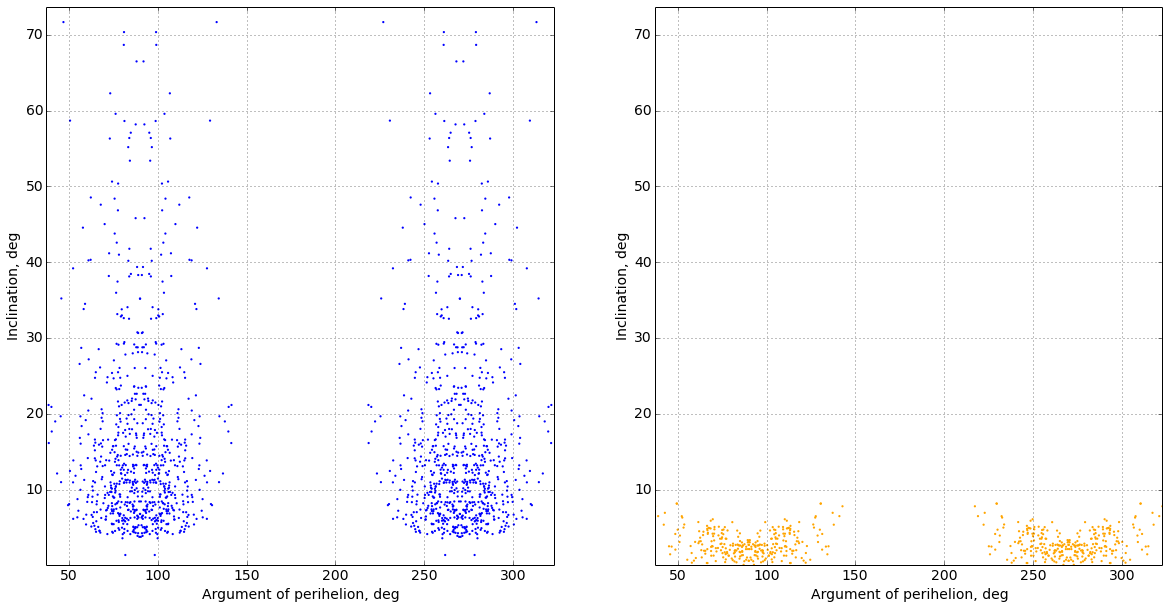

In [13]:
cutcol = ['w', 'i']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_atiras_atens_se, nohaz_gen_atiras_atens_se])

In [14]:
cutcol = ['w', 'i']
clf_aa = svm.SVC(gamma=80.0, C=0.4, class_weight={0: 1.1}) #class_weight={0: 1.5} 
#(20 0.5), (30 0.1) (200 0.1)
splitres = al.split_by_clf(clf_aa, cutcol, haz_gen_atiras_atens_se,
                                           nohaz_gen_atiras_atens_se,
                                           haz_gen_atiras_atens,
                                           nohaz_gen_atiras_atens)

haz_gen_atiras_atens_wi, nohaz_gen_atiras_atens_wi = splitres[0]
haz_gen_atiras_atens_wi__, nohaz_gen_atiras_atens_wi__ = splitres[1]
haz_gen_aa_wi_sc = splitres[2]

purity of PHA region: 0.902097902098
number of PHAs in the PHA region: 129
number of NHAs in the PHA region: 14

purity of NHA region: 0.954761904762
number of PHAs in the NHA region: 19
number of NHAs in the NHA region: 401

fraction of correctly classified PHAs: 0.871621621622


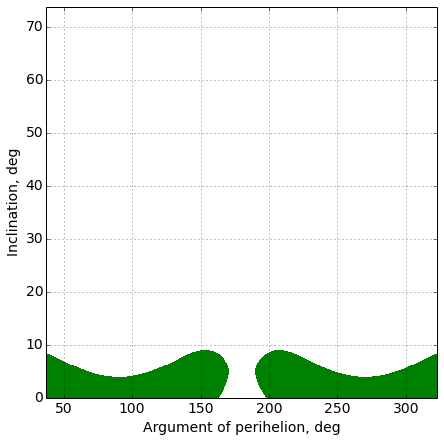

In [22]:
plotgrid = np.array([[0.0, 0.0], [1.0, 1.0]])
cutcol = ['w', 'i']
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_classifier(plotgrid, clf_aa, num=400, scales=haz_gen_aa_wi_sc, 
                   labels = labels, cmap='ocean_r', figsize=(7,7))

In [38]:
haz_extracted.append(haz_gen_atiras_atens_wi)
nohaz_trapped.append(nohaz_gen_atiras_atens_wi)

## Extract Apollos

In [17]:
haz_gen_apollo, haz_gen_apollo_num = rdb.get_apollos(haz_gen)
nohaz_gen_apollo, nohaz_gen_apollo_num = rdb.get_apollos(nohaz_gen)

In [18]:
# vd.display_allparams([haz_gen_apollo, nohaz_gen_apollo], vd.combs, vd.colnames)

** Amplify Apollos by their symmetric copies over the 'w' parameter **

In [19]:
haz_gen_apollo_se = ld.add_doublemirror_column(haz_gen_apollo, 'w', 180.0)
nohaz_gen_apollo_se = ld.add_doublemirror_column(nohaz_gen_apollo, 'w', 180.0)

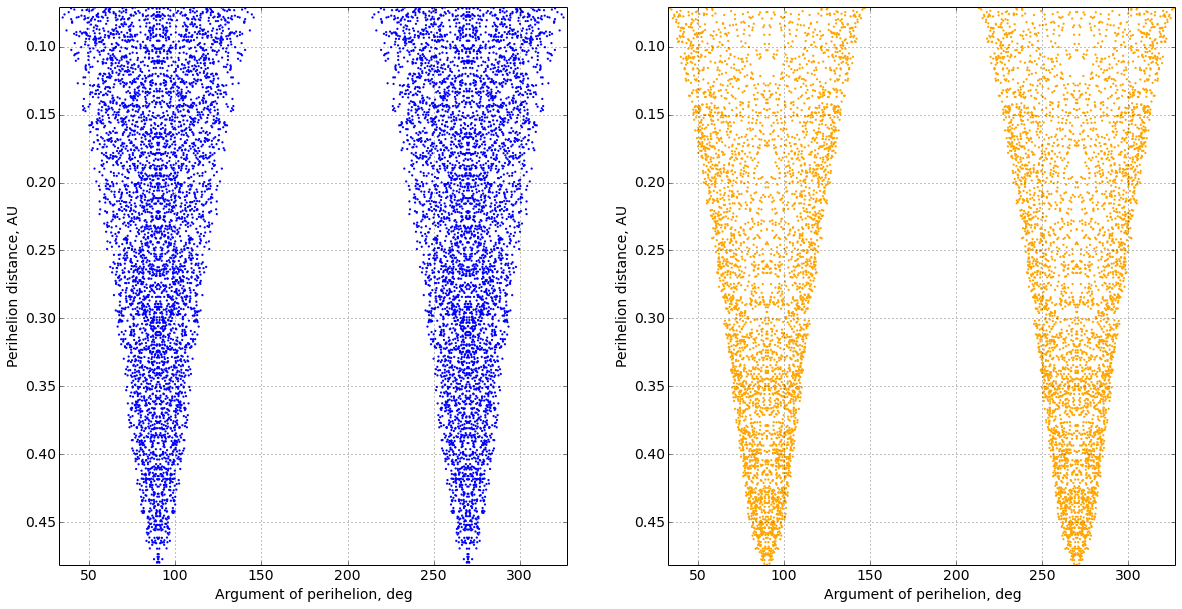

In [20]:
cutcol = ['w', 'q']
labels = [vd.colnames[nm] for nm in cutcol]
vd.display_param2d(cutcol, labels, [haz_gen_apollo_se, nohaz_gen_apollo_se], invertaxes=[0,1])

** Prepare 'w-q' domain mask to exclude out-of-domain points from the plot **

In [27]:
cutcol = ['w', 'q']
labels = [vd.colnames[nm] for nm in cutcol]

clfmask = svm.SVC(gamma=10.0, C=500.0, class_weight={1: 10})
clfmask = al.sgmask_clf(haz_gen_apollo_se, nohaz_gen_apollo_se, 
                     haz_genu_rest, nohaz_genu_rest, clfmask, cutcol)

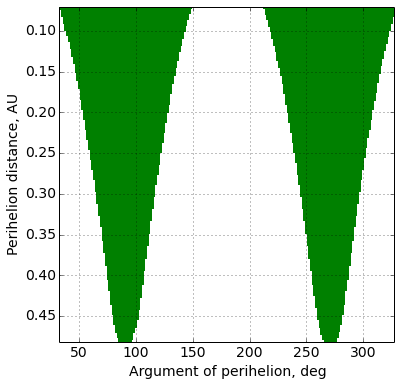

In [28]:
plotgrid = np.array([[0.0, 0.0], [1.0, 1.0]])
scales = ld.dfcommon_bounds([haz_gen_apollo_se, nohaz_gen_apollo_se], cutcol)
vd.plot_classifier(plotgrid, clfmask, num=200, figsize=(6,6), scales=scales, 
                   labels = labels, cmap='ocean_r', invertaxes=[0, 1])

** Split Apollos by 'w-q-i' surface **

In [21]:
cutcol = ['w', 'q', 'i']
clf_apollo_wqi = svm.SVC(gamma=20.0, C=0.5)
splitres = al.split_by_clf(clf_apollo_wqi, cutcol,   haz_gen_apollo_se,
                                                     nohaz_gen_apollo_se,
                                                     haz_gen_apollo,
                                                     nohaz_gen_apollo)

haz_gen_apollo_wqi, nohaz_gen_apollo_wqi = splitres[0]
haz_gen_apollo_wqi__, nohaz_gen_apollo_wqi__ = splitres[1]
haz_gen_apollo_wqi_sc = splitres[2]

purity of PHA region: 0.939252336449
number of PHAs in the PHA region: 2010
number of NHAs in the PHA region: 130

purity of NHA region: 0.93338651775
number of PHAs in the NHA region: 167
number of NHAs in the NHA region: 2340

fraction of correctly classified PHAs: 0.92328892972


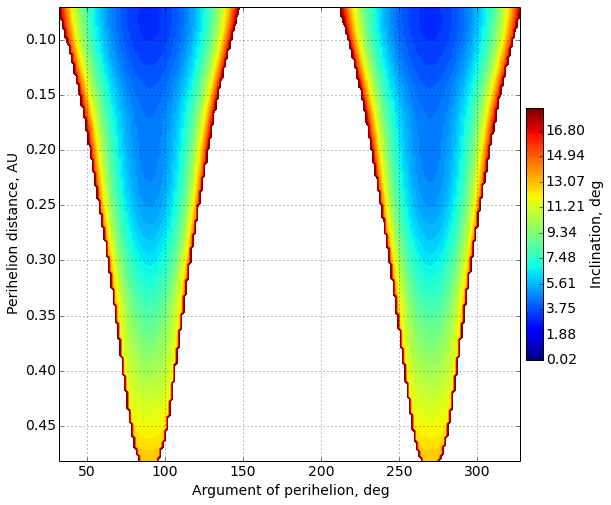

In [30]:
cutcol = ['w', 'q', 'i']
clf_masks = [(clfmask, 0)]
labels = [vd.colnames[nm] for nm in cutcol]
vd.plot_clf3d(clf_apollo_wqi, num=200, labels=labels, figsize=(8,7), mode='2d', 
              scales=haz_gen_apollo_wqi_sc, clf_masks=clf_masks, invertaxes=[0, 1]) 

In [39]:
haz_extracted.append(haz_gen_apollo_wqi)
nohaz_trapped.append(nohaz_gen_apollo_wqi)

## Count down split quality

In [42]:
haz_correct_num = sum(map(len, haz_extracted))
nohaz_trapped_num = sum(map(len, nohaz_trapped))

haz_correct_fraction = float(haz_correct_num)/len(haz_gen)
nohaz_trapped_fraction = float(nohaz_trapped_num)/len(nohaz_gen)

haz_extracted_purity = float(haz_correct_num)/(nohaz_trapped_num + haz_correct_num)

print "Number of correctly classified PHAs", haz_correct_num
print "Number of trapped NHAs:", nohaz_trapped_num
print
print "Mass fraction of correctly classified PHAs:", haz_correct_fraction
print "Mass fraction of trapped NHAs:", nohaz_trapped_fraction
print "Cummulative purity of the outlined PHA regions:", haz_extracted_purity

Number of correctly classified PHAs 2139
Number of trapped NHAs: 144

Mass fraction of correctly classified PHAs: 0.92
Mass fraction of trapped NHAs: 0.0499133448873
Cummulative purity of the outlined PHA regions: 0.936925098555
